![](https://hdwallpaperim.com/wp-content/uploads/2017/08/23/459593-flowers-plants-leaves-748x468.jpg)

I had never tried coding up a deep learning model using PyTorch. I had always stuck to FastAI Library for producing best in class computer vision models. That was the usual for me for mainly two reasons:
   1. It takes way less code to get a model to work
   2. It works insanely good with state-of-the-art accuracies.

But keep this in mind, FastAI is built on top of PyTorch. It is consists of perfect combination of image transformation presets. These presets are highly generalised, that is, they work for virtually any sort of dataset which is being used under Computer Vision. I really wanted to see why is PyTorch so hyped after all.

# Table of Content

1. Importing Libararies
2. Defining Transformations
3. Defining the Directories
4. Visualizing
5. Training the model
6. Predicting

# Importing Libararies:

Importing necessary libraries for very obvious reasons:

In [34]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time
import copy

# Defining Transformations
Transformations here refer to playing with images. Like, seriously the pytorch library is like: it seems like you don't have many images so what if I flip them around a bit to make it challenging for the model to overfit on this data? This way, it helps us get more images.

In [43]:
data_transforms = {
    'train': transforms.Compose([ 
        transforms.RandomResizedCrop(256),              # It crops the images to a square of 256 px a side.
        transforms.RandomHorizontalFlip(),              # It flips images horizontally.
        transforms.RandomAffine(90, scale = (1, 1.5)),  # RandomAffine rotates images to some certain degrees, it fills space with black gradient.
        transforms.ToTensor(),                                   
        transforms.Normalize([.485, .456, .406], [ .229, .224, .225]) # This normalizes the Tensors of the Images using ImageNets' presets.
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(90, scale = (1, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [ .229, .224, .225])
    ]),
}

# Defining Directories:
The directories are defined as where the images are.

In [44]:
DataDir = '../input/cotton-disease-dataset/Cotton Disease'

images = {x: datasets.ImageFolder(os.path.join(DataDir, x), data_transforms[x])
          for x in ['train', 'val']}

# This loads data for the model:
dataloaders = {x: torch.utils.data.DataLoader(images[x], batch_size = 4, shuffle = True, num_workers = 4)
               for x in ['train', 'val']}

# These are the number of images in both, training and validation sets:
dataset_sizes = {x: len(images[x]) for x in ['train', 'val']}

# These refer to the categories in the data:
class_names = images['train'].classes


# Visualizing:
Okay, so we have to define a function which predicts on new images that the model has not seen after it is done training on the given data, lets make that and lets visualize what we have here in the data too.

In [45]:
# Defining a function to visualize the model:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finally lets end the suffering and take a look at the images, a bit of angry text there but bear with me:

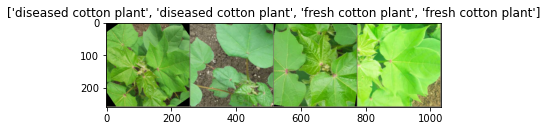

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)


imshow(out, title = [class_names[x]  for x in classes])

## Training the Model:
Finally we are training the model!

In [47]:
# def a function for the latter:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
# Getting our beloved CUDA:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
# Using transfer learning or using a pretrained ResNet50, same thing.
model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

# Handing the model to our Device:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
#TRAINING THE MODEL FINALLY:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs = 10)

Epoch 0/9
----------
train Loss: 0.7792 Acc: 0.7063
val Loss: 0.3891 Acc: 0.8379

Epoch 1/9
----------
train Loss: 0.5602 Acc: 0.8052
val Loss: 0.1592 Acc: 0.9447

Epoch 2/9
----------
train Loss: 0.4750 Acc: 0.8242
val Loss: 0.1447 Acc: 0.9407

Epoch 3/9
----------
train Loss: 0.3982 Acc: 0.8585
val Loss: 0.1397 Acc: 0.9486

Epoch 4/9
----------
train Loss: 0.3312 Acc: 0.8811
val Loss: 0.1516 Acc: 0.9447

Epoch 5/9
----------
train Loss: 0.3883 Acc: 0.8611
val Loss: 0.1637 Acc: 0.9407

Epoch 6/9
----------
train Loss: 0.3374 Acc: 0.8908
val Loss: 0.2058 Acc: 0.9209

Epoch 7/9
----------
train Loss: 0.2445 Acc: 0.9200
val Loss: 0.1221 Acc: 0.9565

Epoch 8/9
----------
train Loss: 0.1843 Acc: 0.9354
val Loss: 0.0972 Acc: 0.9684

Epoch 9/9
----------
train Loss: 0.1767 Acc: 0.9462
val Loss: 0.0819 Acc: 0.9802

Training complete in 5m 42s
Best val Acc: 0.980237


# Predicting:
I mean why not we got 98.02% accuracy:

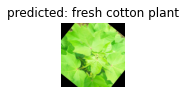

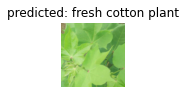

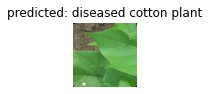

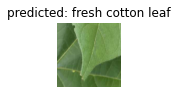

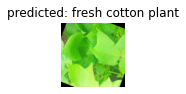

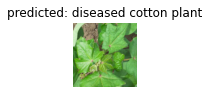

In [51]:
visualize_model(model_ft)

Thank you for going through my note book! :D 

Shameless self promotion ahead:
If you liked this, maybe upvote or give me a follow on kaggle?
You can hit me up at these places too:

[**LinkedIn**](https://www.linkedin.com/in/vyom-bhatia-40ba79181/)
                               


[**Instagram**](https://www.instagram.com/vyombhatia/)